# La régression

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from datetime import (
    datetime as DateTime, 
    timedelta as TimeDelta)

from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients
from sklearn.linear_model import LinearRegression

In [2]:
df_global = import_data()
clients = group_by_clients(df_global)
n = len(clients)

## v1 - sur les données brutes

### Mise en place des modèles

In [3]:
# Préparation des données de train / test
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["jour", "forecasted_consumption"], ["real_consumption"])

In [4]:
# création des modèles : 
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [5]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

### Evaluation des modèles

In [6]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

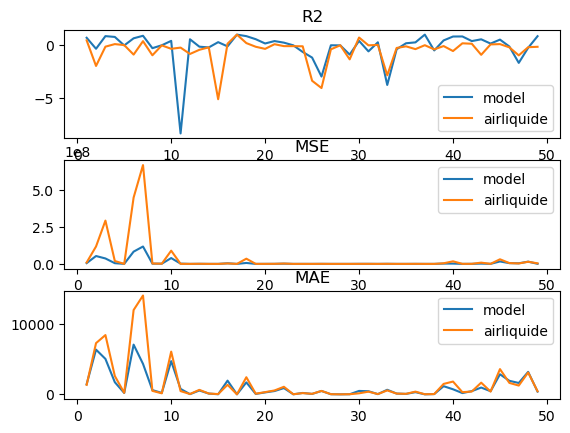

In [7]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Score du modèle

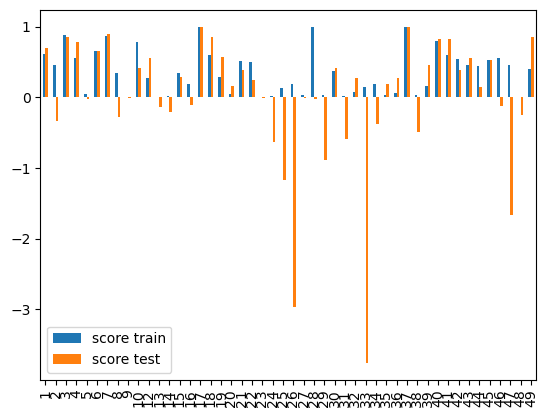

In [49]:
score = np.empty((n,2))
for i, model in enumerate(models):
    score[i,0] = model.score(X_train[i], y_train[i])
    score[i,1] = model.score(X_test[i], y_test[i])
score = pd.DataFrame(score, columns = ["score train", "score test"]).rename(index = lambda x : x+1)
score.drop(11).plot.bar(); 

## v2 - on rajoute les données du CAC-40 

In [50]:
# on ajoute les données du CAC aux dataframe global
df_global_with_cac = df_global.copy()
cac = pd.read_csv("../data/^FCHI.csv")
cac["horodate"] = pd.to_datetime(cac["Date"])
cac = cac.drop(["High", "Low", "Date", "Close", "Adj Close", "Volume"], axis = 1)
cac = cac[cac["horodate"] <= pd.to_datetime("2023-01-31")]
df_global_with_cac = pd.merge(df_global_with_cac, cac, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()
df_global_with_cac.rename({"Open": "CAC"}, axis = 1, inplace = True)

In [51]:
# on sépare à nouveau en client 
clients_CAC = group_by_clients(df_global_with_cac)

In [52]:
# on peut alors créer les données de test : 
X_train_CAC, X_test_CAC, y_train_CAC, y_test_CAC, test_data_CAC = make_train_test_set(clients_CAC, ["jour", "forecasted_consumption", "CAC"], ["real_consumption"])

In [53]:
# création des modèles : 
models_CAC = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_CAC): 
    model.fit(X_train_CAC[i], y_train_CAC[i])

In [54]:
y_pred_CAC = []
for i, model in enumerate(models_CAC) : 
    y_pred_CAC.append(model.predict(X_test_CAC[i]).reshape(len(X_test_CAC[i])))

### Evaluation des modèles

In [55]:
evaluation_model_CAC = []
for i in range(n): 
    evaluation_model_CAC.append(metrics(test_data_CAC[i]["real_consumption"], y_pred_CAC[i]))

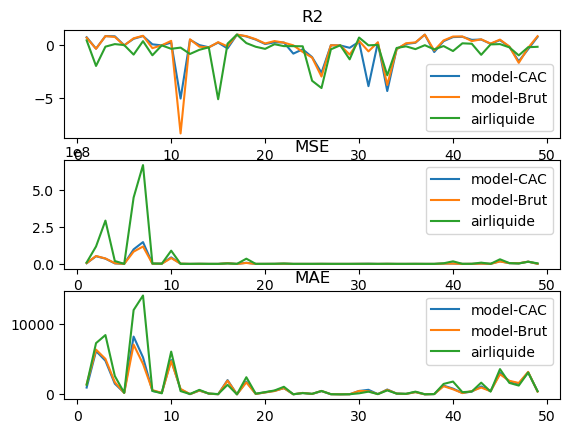

In [56]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_CAC], label = "model-CAC")
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model-Brut")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Score des modèles

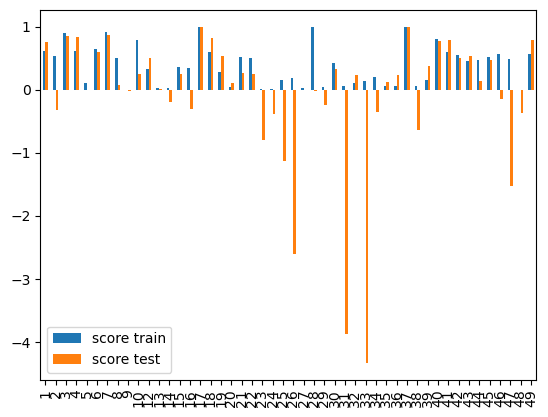

In [60]:
score = np.empty((n,2))
for i, model in enumerate(models_CAC):
    score[i,0] = model.score(X_train_CAC[i], y_train_CAC[i])
    score[i,1] = model.score(X_test_CAC[i], y_test_CAC[i])
score = pd.DataFrame(score, columns = ["score train", "score test"]).rename(index = lambda x : x+1)
score.drop(11).plot.bar(); 

## v3 - Les données de CAC avec un décalage de deux semaines

L'entreprise finalise ses prédictions deux semaines avant la date réelle. Elle est donc influencée par les données du CAC à deux semaines. 

In [61]:
df_global_with_cac_v2 = df_global.copy()
cac = pd.read_csv("../data/^FCHI.csv")
cac["horodate"] = pd.to_datetime(cac["Date"])
cac = cac.drop(["High", "Low", "Date", "Close", "Adj Close", "Volume"], axis = 1)
cac["horodate"] = cac["horodate"] + pd.Timedelta(days=14) #on fait le décalage temporel 
cac = cac[(cac["horodate"] <= pd.to_datetime("2023-01-31")) & (cac["horodate"] >= pd.to_datetime("2021-01-01"))]
df_global_with_cac_v2 = pd.merge(df_global_with_cac_v2, cac, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna()
df_global_with_cac_v2.rename({"Open": "CAC"}, axis = 1, inplace = True)

In [62]:
# on sépare à nouveau en client 
clients_CAC_v2 = group_by_clients(df_global_with_cac_v2)

In [63]:
# on peut alors créer les données de test : 
X_train_CAC_v2, X_test_CAC_v2, y_train_CAC_v2, y_test_CAC_v2, test_data_CAC_v2 = make_train_test_set(clients_CAC_v2, ["jour", "forecasted_consumption", "CAC"], ["real_consumption"])

In [64]:
# création des modèles : 
models_CAC_v2 = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_CAC_v2): 
    model.fit(X_train_CAC_v2[i], y_train_CAC_v2[i])

In [65]:
y_pred_CAC_v2 = []
for i, model in enumerate(models_CAC_v2) : 
    y_pred_CAC_v2.append(model.predict(X_test_CAC_v2[i]).reshape(len(X_test_CAC_v2[i])))

### Evaluation des modèles

In [66]:
evaluation_model_CAC_v2 = []
for i in range(n): 
    evaluation_model_CAC_v2.append(metrics(test_data_CAC_v2[i]["real_consumption"], y_pred_CAC_v2[i]))

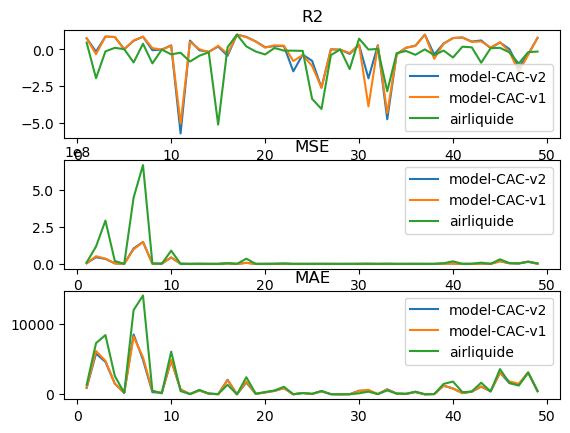

In [67]:
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_CAC_v2], label = "model-CAC-v2")
    ax[i].plot(X, [x[i] for x in evaluation_model_CAC], label = "model-CAC-v1")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

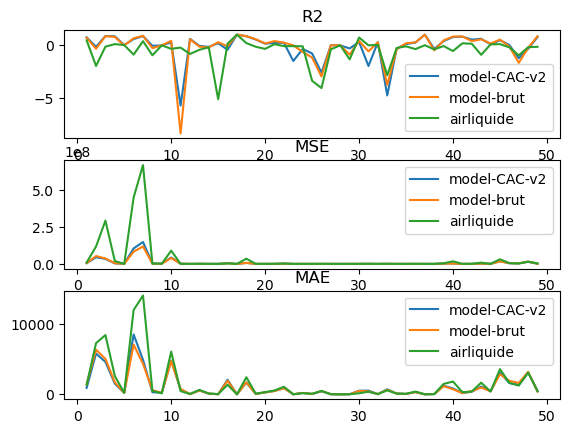

In [68]:
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_CAC_v2], label = "model-CAC-v2")
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model-brut")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Score des modèles

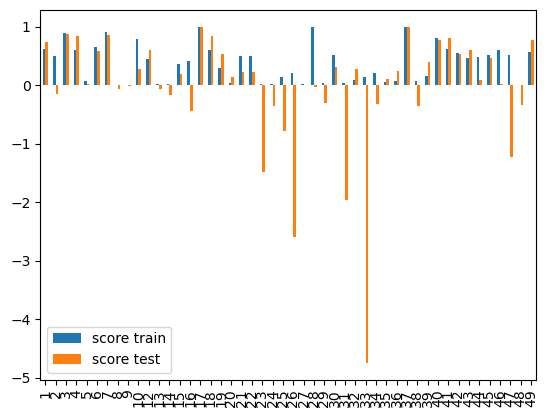

In [70]:
score = np.empty((n,2))
for i, model in enumerate(models_CAC_v2):
    score[i,0] = model.score(X_train_CAC_v2[i], y_train_CAC_v2[i])
    score[i,1] = model.score(X_test_CAC_v2[i], y_test_CAC_v2[i])
score = pd.DataFrame(score, columns = ["score train", "score test"]).rename(index = lambda x : x+1)
score.drop(11).plot.bar(); 

## v4 - Données du gaz naturel

In [71]:
gas = pd.read_csv("../data/gas.csv")
gas["horodate"] = pd.to_datetime(gas["horodate"])
gas["horodate"] = gas["horodate"] + pd.Timedelta(days = 14)
gas = gas[(gas["horodate"] <= pd.to_datetime("2023-01-31")) & (gas["horodate"] >= pd.to_datetime("2021-01-01"))]

In [72]:
df_gas = df_global.copy()
df_gas = pd.merge(df_gas, gas, on = ["horodate"], how = "left").sort_values(["id_client", "horodate"]).dropna().reset_index().drop("index", axis = 1)

In [73]:
df_gas

,id_client,horodate,real_consumption,forecasted_consumption,prediction,Gas Price
0,1,2021-01-01,8396.00,8400.0,8323.319457,2.73
1,1,2021-01-04,8397.00,8400.0,8420.826672,2.68
2,1,2021-01-05,8395.73,8400.0,8123.422185,2.76
3,1,2021-01-06,8397.63,8400.0,8133.347899,2.76
4,1,2021-01-07,8395.00,8400.0,8230.745858,2.68
...,...,...,...,...,...,...
25425,49,2023-01-24,0.00,0.0,0.000000,3.32
25426,49,2023-01-25,0.00,0.0,0.000000,3.41
25427,49,2023-01-26,0.00,0.0,0.000000,3.47
25428,49,2023-01-27,0.00,0.0,0.000000,3.43


In [74]:
# on sépare à nouveau en client 
clients_gas = group_by_clients(df_gas)

In [75]:
X_train_gas, X_test_gas, y_train_gas, y_test_gas, test_data_gas = make_train_test_set(clients_gas, ["jour", "forecasted_consumption", "Gas Price"], ["real_consumption"])

In [76]:
# création des modèles : 
models_gas = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_gas): 
    model.fit(X_train_gas[i], y_train_gas[i])

In [77]:
y_pred_gas = []
for i, model in enumerate(models_gas) : 
    y_pred_gas.append(model.predict(X_test_gas[i]).reshape(len(X_test_gas[i])))

### Evaluation des modèles

In [78]:
evaluation_model_gas = []
for i in range(n): 
    evaluation_model_gas.append(metrics(test_data_gas[i]["real_consumption"], y_pred_gas[i]))

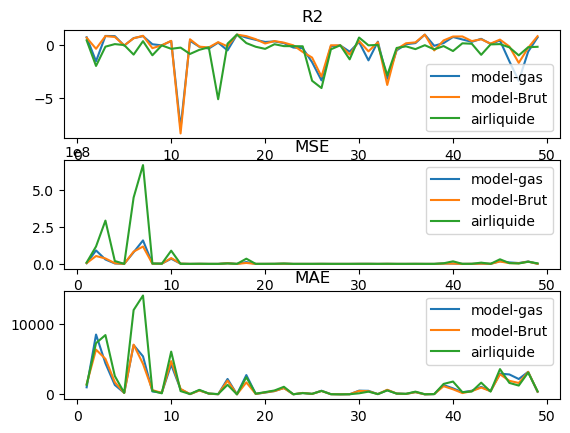

In [79]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model_gas], label = "model-gas")
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model-Brut")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Score des modèles

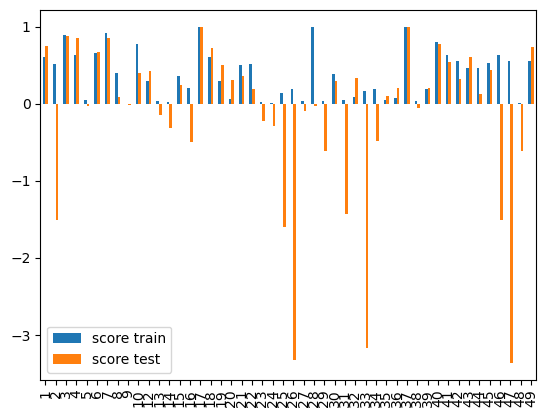

In [80]:
score = np.empty((n,2))
for i, model in enumerate(models_gas):
    score[i,0] = model.score(X_train_gas[i], y_train_gas[i])
    score[i,1] = model.score(X_test_gas[i], y_test_gas[i])
score = pd.DataFrame(score, columns = ["score train", "score test"]).rename(index = lambda x : x+1)
score.drop(11).plot.bar(); 